![data-x](https://raw.githubusercontent.com/afo/data-x-plaksha/master/imgsource/dx_logo.png)


# Data-X Notebook: Word2vec
#### Using NLP with Word2Vec in Python to do sentiment analysis on IMDB movie reviews


#  Following  steps: 
1. Reading of file labeledTrainData.tsv from data folder in a dataframe `train`.
2. Clean the reviews in the input file.
3. Use cleaned reviews to generate word vectors for this corpus.
4. Train a classifier on Word vectors represntation of reviews for sentiment analysis.

In [1]:
#make compatible with Python 2 and Python 3
from __future__ import print_function, division, absolute_import 

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


## Dataset

The labeled training data set consists of 25,000 IMDB movie reviews. There is also an unlabeled test set with 25,000 IMDB movie reviews. The sentiment of the reviews are binary, meaning an IMDB rating < 5 results in a sentiment score of 0, and a rating >=7 have a sentiment score of 1 (no reviews with score 5 or 6 are included in the analysis). No individual movie has more than 30 reviews.

## File description

* **labeledTrainData** - The labeled training set. The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review. 

* **testData** - The unlabeled test set. 25,000 rows containing an id, and text for each review. 

## Data columns
* **id** - Unique ID of each review
* **sentiment** - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
* **review** - Text of the review


## 1. Dataset statistics

In [2]:
import numpy as np
import pandas as pd       
train = pd.read_csv("data/labeledTrainData.tsv",delimiter="\t")

In [3]:
train.shape

(25000, 3)

In [4]:
train.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [5]:
# import packages

import bs4 as bs
import nltk
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/lizhi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div id='sec3'></div>

##  2. Cleaning the reviews



We'll create a function called `review_cleaner` that reads in a review and:

- Removes HTML tags (using beautifulsoup)
- Removes non-letters (using regular expression)
- Converts all words to lowercase letters and tokenizes them (using .split() method on the review strings, so that every word in the review is an element in a list)
- Removes all the English stopwords from the list of movie review words
- Join the words back into one string seperated by space, append the emoticons to the end



In [6]:
from nltk.corpus import stopwords
from nltk.util import ngrams

ps = PorterStemmer()
wnl = WordNetLemmatizer()

def review_cleaner(review,lemmatize=True,stem=False):
    '''
    Clean and preprocess a review.

    1. Remove HTML tags
    2. Use regex to remove all special characters (only keep letters)
    3. Make strings to lower case and tokenize / word split reviews
    4. Remove English stopwords
    5. Rejoin to one string
    '''
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    #1. Remove HTML tags
    review = bs.BeautifulSoup(review).text
    
    #2. Remove punctuation
    review = re.sub("[^a-zA-Z]", " ",review)
    
    #3. Tokenize into words (all lower case)
    review = review.lower().split()
    
    #4.Set stopwords
    eng_stopwords = set(stopwords.words("english"))

    clean_review=[]
    for word in review:
        if word not in eng_stopwords:
            if lemmatize is True:
                word=wnl.lemmatize(word)
            elif stem is True:
                if word == 'oed':
                    continue
                word=ps.stem(word)
            clean_review.append(word)
    return(clean_review)

In [7]:
num_reviews = len(train['review'])

review_clean_original = []

for i in range(0,num_reviews):
    if( (i+1)%5000 == 0 ):
        # print progress
        print("Done with %d reviews" %(i+1)) 
    review_clean_original.append(review_cleaner(train['review'][i]))

Done with 5000 reviews
Done with 10000 reviews
Done with 15000 reviews
Done with 20000 reviews
Done with 25000 reviews


In [8]:
print(train['review'][0])

With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally star

In [9]:
print(' '.join(review_clean_original[0]))

stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighty maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle message mj feeling towards press also obvious message drug bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fan would say made fan true really nice actual feature film bit finally start minute excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord want mj dead bad beyond mj overheard plan nah joe pesci character ranted wanted people know supplying drug etc dunno maybe hate mj music lot cool thing like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually director hate working one kid let al

In [10]:
len(review_clean_original)

25000

## 3. Convert Words to Distributed representation i.e train Word2Vec Model:

ref: https://radimrehurek.com/gensim/models/word2vec.html

In [11]:
!pip install gensim

In [12]:
sentences=review_clean_original
# Set values for various parameters
num_features = 100    # Word vector dimensionality                      
min_word_count = 40   # ignore all words with total frequency lower than this                       
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    


# Initialize and train the model (this will take some time)
from gensim.models import word2vec

print("Training word2vec model... ")
model = word2vec.Word2Vec(sentences,
                          workers=num_workers,
                          size=num_features,
                          min_count=min_word_count,
                          window=context)
print("Training finished!")

# save the model for later use. You can load it later using Word2Vec.load()
model_name = "100features_40minwords_10context"
model.save(model_name)

Training word2vec model... 
Training finished!


### You can also use pretrained word2vec models:
Download the Google pretrained model from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit  
Once you download, unzip the file and you will get another zip file named GoogleNews-vectors-negative300.bin.  
Then use the following code to load the model.  
`Gmodel = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)`

## Exploring the Model Results





In [13]:
# Get vocabulary count of the model
vocab_tmp = list(model.wv.vocab)
print('Vocab length:',len(vocab_tmp))

Vocab length: 7560


In [14]:
# Get Vocabulary words
vocab_tmp

['stuff',
 'going',
 'moment',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary',
 'watched',
 'maybe',
 'want',
 'get',
 'certain',
 'insight',
 'guy',
 'thought',
 'really',
 'cool',
 'eighty',
 'make',
 'mind',
 'whether',
 'guilty',
 'innocent',
 'part',
 'biography',
 'feature',
 'film',
 'remember',
 'see',
 'cinema',
 'originally',
 'released',
 'subtle',
 'message',
 'feeling',
 'towards',
 'press',
 'also',
 'obvious',
 'drug',
 'bad',
 'kay',
 'visually',
 'impressive',
 'course',
 'michael',
 'jackson',
 'unless',
 'remotely',
 'like',
 'anyway',
 'hate',
 'find',
 'boring',
 'may',
 'call',
 'making',
 'movie',
 'fan',
 'would',
 'say',
 'made',
 'true',
 'nice',
 'actual',
 'bit',
 'finally',
 'start',
 'minute',
 'smooth',
 'criminal',
 'sequence',
 'joe',
 'convincing',
 'powerful',
 'lord',
 'dead',
 'beyond',
 'plan',
 'character',
 'wanted',
 'people',
 'know',
 'etc',
 'lot',
 'thing',
 'turning',
 'car',
 'robot',
 'whole',
 'speed',
 'demon',


In [15]:
# Get the Word embedding 
model['stuff']

array([-0.9760443 ,  0.30890912,  0.5315477 ,  1.1900043 ,  0.19504783,
       -0.64932644, -0.1492197 , -0.6666901 , -0.37806994, -1.1208332 ,
       -0.05933334, -0.9218918 ,  0.4322388 , -1.1201409 ,  0.5483526 ,
       -0.0022283 , -0.39365575, -0.57585114, -0.8161798 , -0.5844884 ,
       -0.59362113,  1.8956821 ,  0.1385762 , -0.13067211,  0.7983439 ,
        0.66020656,  0.70629084, -0.85534215,  0.838867  , -0.91672283,
       -0.14070666,  0.49919164,  0.41192135,  0.80408895,  0.7975015 ,
       -0.9838614 , -1.0241945 , -1.6595939 ,  0.43352807, -0.6857916 ,
       -1.0179859 ,  0.8640638 , -0.15403059,  1.1390316 ,  0.9911375 ,
        0.4173049 , -0.33176148,  0.9952829 ,  0.36288828,  0.80194193,
        0.32173276,  0.44600773,  0.57576334, -1.4324917 , -0.7642319 ,
       -1.1755241 ,  0.84571826,  1.676446  ,  0.6409225 ,  0.01744706,
        0.30876032, -0.33793357,  0.0498184 ,  0.6827222 ,  0.39246547,
       -0.02703848, -0.10270792,  1.3142775 , -0.86033237,  0.72

In [16]:
# Get cosine similarity of words
from sklearn.metrics.pairwise import cosine_similarity

model.similarity('movie', 'film')

0.55957437

In [17]:
model.similarity('actor', 'actress')

0.7079878

In [18]:
model.similarity('boring', 'dull')  

0.85111135

In [19]:
model.most_similar(positive=['germany', 'tokyo'], negative=['berlin'])
# germany + tokyo - berlin = japan =>
# germany - berlin = japan - tokyo

[('japan', 0.7887859344482422),
 ('russia', 0.7453195452690125),
 ('korean', 0.7286350727081299),
 ('tribe', 0.7268410325050354),
 ('colony', 0.7179082632064819),
 ('soviet', 0.7174085974693298),
 ('galaxy', 0.7155004143714905),
 ('north', 0.7140334248542786),
 ('population', 0.7125791907310486),
 ('region', 0.7121478319168091)]

In [20]:
model.most_similar(positive=['drove', 'run'], negative=['drive'])
# drove + run - drive = ran =>
# drove - drive = ran - run

[('ran', 0.6961075663566589),
 ('popped', 0.6872938871383667),
 ('running', 0.6822405457496643),
 ('jumped', 0.6714857816696167),
 ('disappeared', 0.6572972536087036),
 ('clock', 0.645153284072876),
 ('burned', 0.6249134540557861),
 ('sitting', 0.6202572584152222),
 ('station', 0.6183355450630188),
 ('walk', 0.608769416809082)]

In [21]:
model.doesnt_match("man woman child kitchen".split())

'kitchen'

In [22]:
model.doesnt_match("great good fantastic bad".split())

'bad'

In [23]:
model.doesnt_match("france face berkeley london athens".split())

'face'

In [24]:
model.most_similar("man")

[('woman', 0.5199404954910278),
 ('lady', 0.5182021260261536),
 ('men', 0.4822551906108856),
 ('bride', 0.4630507230758667),
 ('invisible', 0.45408663153648376),
 ('doctor', 0.4394615888595581),
 ('innocent', 0.43859538435935974),
 ('melting', 0.43721187114715576),
 ('blind', 0.42832815647125244),
 ('jealous', 0.42458057403564453)]

In [25]:
model.most_similar("movie")

[('flick', 0.5837092399597168),
 ('honestly', 0.5759040117263794),
 ('film', 0.5595743060112),
 ('thats', 0.5542935132980347),
 ('anyway', 0.5273988246917725),
 ('amazed', 0.5221498012542725),
 ('sure', 0.5146435499191284),
 ('ok', 0.5145382881164551),
 ('sucked', 0.5123980045318604),
 ('damn', 0.510209321975708)]

In [26]:
model.most_similar("awful")

[('terrible', 0.9183237552642822),
 ('horrible', 0.8989686965942383),
 ('suck', 0.8410872220993042),
 ('atrocious', 0.8395564556121826),
 ('dreadful', 0.8240537047386169),
 ('lousy', 0.816869854927063),
 ('abysmal', 0.8125045895576477),
 ('horrid', 0.7992112040519714),
 ('pathetic', 0.7920926213264465),
 ('horrendous', 0.7578076124191284)]

In [27]:
from gensim.models import Word2Vec
# Load the trained modelNumeric Representations of Words
model = Word2Vec.load("100features_40minwords_10context")

Now that we have a trained model with some semantic understanding of words, how should we use it? If you look beneath the hood, the Word2Vec model trained in earlier consists of a feature vector for each word in the vocabulary, stored in a numpy array called "wv.syn0":

In [28]:
model.wv.syn0

array([[ 0.74609727,  0.2538714 , -1.2040464 , ..., -0.82696956,
         1.7288262 , -0.11489248],
       [-0.18397342,  0.61524975, -1.848004  , ...,  0.23006296,
         0.62571037,  0.06024686],
       [-0.15791509, -0.61295426, -1.6113374 , ..., -1.4057186 ,
         0.0254542 , -0.62872666],
       ...,
       [ 0.05395775, -0.24648918, -0.18074003, ...,  0.27541137,
        -0.3363262 , -0.31549454],
       [ 0.2847946 , -0.07557368, -0.07363155, ...,  0.18921879,
        -0.5887827 , -0.37207934],
       [ 0.24040367, -0.26685056, -0.08737151, ...,  0.01636804,
        -0.03285415, -0.09988925]], dtype=float32)

In [29]:
model.wv.syn0.shape

(7560, 100)

In [30]:
model.corpus_count

25000

In [31]:
# Get vocabulary count of the model
vocab_tmp = list(model.wv.vocab)
print('Vocab length:',len(vocab_tmp))

Vocab length: 7560


In [32]:
# Get distributional representation of each word
X = model[vocab_tmp]

In [33]:
from sklearn import decomposition
# get two principle components of the feature space
pca= decomposition.PCA(n_components=2).fit_transform(X)

In [34]:
pca

array([[-4.3691654 , -2.5272348 ],
       [-2.6855538 , -4.3985996 ],
       [-2.182818  ,  0.6105446 ],
       ...,
       [-0.58882606, -0.06914005],
       [ 0.866978  , -0.61161613],
       [ 1.5822442 , -0.41884407]], dtype=float32)

In [35]:
pca.shape

(7560, 2)

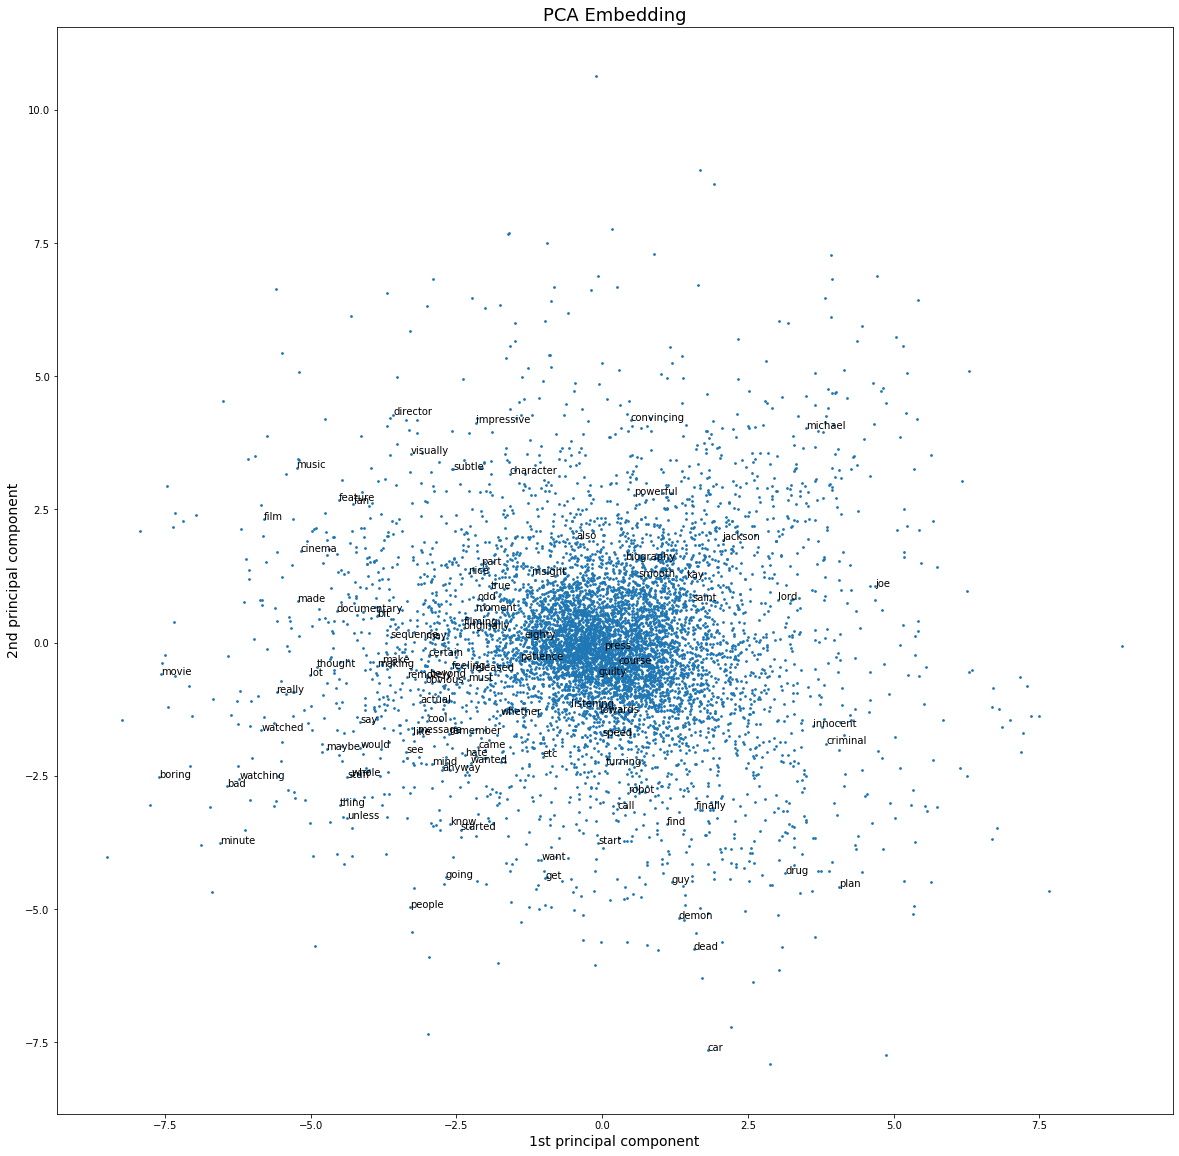

In [36]:
# set figure settings
plt.figure(figsize=(20,20))

# save pca values and vocab in dataframe df
df = pd.concat([pd.DataFrame(pca),pd.Series(vocab_tmp)],axis=1)
df.columns = ['x', 'y', 'word']

plt.xlabel("1st principal component", fontsize=14)
plt.ylabel('2nd principal component', fontsize=14)

plt.scatter(x=df['x'], y=df['y'],s=3)
for i, word in enumerate(df['word'][0:100]):
    plt.annotate(word, (df['x'].iloc[i], df['y'].iloc[i]))
plt.title("PCA Embedding", fontsize=18)
plt.show()

In [37]:
## A popular non-linear dimensionality reduction technique that preserves greatly the local 
## and global structure of the data. Essentially tries to reconstruct the subspace in which the 
## data exists
'''This will take time to run'''

from sklearn import manifold
tsne = manifold.TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

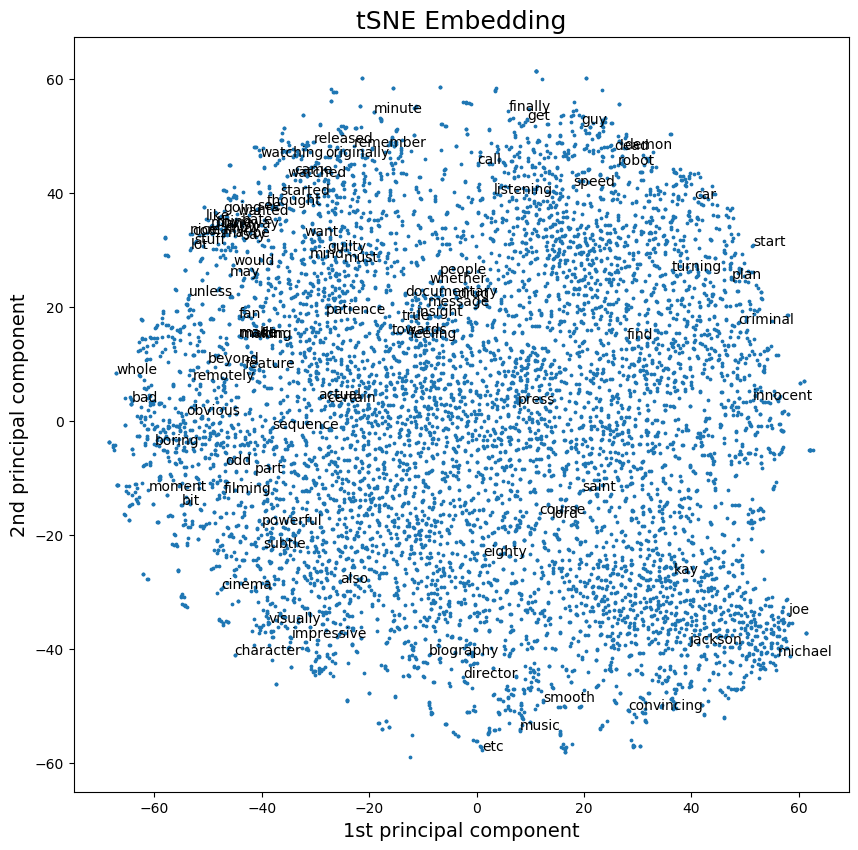

In [38]:
# set figure settings
plt.figure(figsize=(10,10), dpi=100)

# save pca values and vocab in dataframe df
df2 = pd.concat([pd.DataFrame(X_tsne),pd.Series(vocab_tmp)], axis=1)
df2.columns = ['x', 'y', 'word']

plt.xlabel("1st principal component", fontsize=14)
plt.ylabel('2nd principal component', fontsize=14)

plt.scatter(df2['x'], y=df2['y'], s=3)
for i, word in enumerate(df2['word'][0:100]):
    plt.annotate(word, (df2['x'].iloc[i], df2['y'].iloc[i]))
plt.title("tSNE Embedding", fontsize=18)
plt.show()

##  4. Use Word Vectors to create a sentiment analysis model using Random Forest Classifier

#### Vector Averaging to get feature encoding of review:

One challenge with the IMDB dataset is the variable-length reviews. We need to find a way to take individual word vectors and transform them into a feature set that is the same length for every review.

Since each word is a vector in 300-dimensional space, we can use vector operations to combine the words in each review. One method we tried was to simply average the word vectors in a given review (for this purpose, we removed stop words, which would just add noise).

The following code averages the feature vectors, building on our code from earlier sections.

In [39]:
def makeFeatureVec(review, model):
    # Function to average all of the word vectors in a given paragraph
    featureVec =[]
    
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for n,word in enumerate(review):
        if word in index2word_set: 
            featureVec.append(model[word])
            
    # Average the word vectors for a 
    featureVec = np.mean(featureVec,axis=0)
    return featureVec


def getAvgFeatureVecs(reviews, model):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one 
    
    reviewFeatureVecs = []
    # Loop through the reviews
    for counter,review in enumerate(reviews):
        
        # Print a status message every 5000th review
        if counter%5000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))

        # Call the function (defined above) that makes average feature vectors
        vector= makeFeatureVec(review, model)
        reviewFeatureVecs.append(vector)
            
    return reviewFeatureVecs

In [40]:
from sklearn.ensemble import RandomForestClassifier
# # CountVectorizer can actucally handle a lot of the preprocessing for us
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics # for confusion matrix, accuracy score etc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


np.random.seed(0)


def train_sentiment(cleaned_reviews, y=train["sentiment"],max_features=1000):
    '''This function will:
    1. Convert reviews into feature vectors using word2vec.
    2. split data into train and test set.
    3. train a random forest model using train n-gram counts and y (labels)
    4. test the model on your test split
    5. print accuracy of sentiment prediction on test and training data
    6. print confusion matrix on test data results

    To change n-gram type, set value of ngram argument
    To change the number of features you want the countvectorizer to generate, set the value of max_features argument'''

    print("1.Creating Feature vectors using word2vec...\n")

    trainDataVecs = getAvgFeatureVecs(cleaned_reviews, model)
    
   
    print("\n2.Splitting dataset into train and test sets...\n")
    X_train, X_test, y_train, y_test = train_test_split(\
    trainDataVecs, y, random_state=0, test_size=.2)

   
    print("3. Training the random forest classifier...\n")
    
    # Initialize a Random Forest classifier with 75 trees
    forest = RandomForestClassifier(n_estimators = 50) 
    
    # Fit the forest to the training set, word2vecfeatures 
    # and the sentiment labels as the target variable
    forest = forest.fit(X_train, y_train)


    train_predictions = forest.predict(X_train)
    test_predictions = forest.predict(X_test)
    
    train_acc = metrics.accuracy_score(y_train, train_predictions)
    valid_acc = metrics.accuracy_score(y_test, test_predictions)
    print("=================Training Statistics======================\n")
    print("The training accuracy is: ", train_acc)
    print("The validation accuracy is: ", valid_acc)
    print()
    print('CONFUSION MATRIX:')
    print('         Predicted')
    print('          neg pos')
    print(' Actual')
    c=confusion_matrix(y_test, test_predictions)
    print('  neg  ',c[0])
    print('  pos  ',c[1])


In [41]:
train_sentiment(cleaned_reviews=review_clean_original, y=train["sentiment"],max_features=1000)

1.Creating Feature vectors using word2vec...

Review 0 of 25000
Review 5000 of 25000
Review 10000 of 25000
Review 15000 of 25000
Review 20000 of 25000

2.Splitting dataset into train and test sets...

3. Training the random forest classifier...

=================Training Statistics======================

The training accuracy is:  0.9999
The validation accuracy is:  0.8372

CONFUSION MATRIX:
         Predicted
          neg pos
 Actual
  neg   [2092  456]
  pos   [ 358 2094]
